# 1. Load and Visualize Data

In [3]:
# Downloading Dataset
!mkdir /dataset
!wget -P /dataset/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /dataset/train-test-data.zip -d /dataset

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/test/Elmar_Brok_21.jpg  
  inflating: /dataset/test/Elmar_Brok_30.jpg  
  inflating: /dataset/test/Elmar_Brok_31.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_00.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_01.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_10.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_11.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_40.jpg  
  inflating: /dataset/test/Elsa_Zylberstein_41.jpg  
  inflating: /dataset/test/Elton_John_10.jpg  
  inflating: /dataset/test/Elton_John_11.jpg  
  inflating: /dataset/test/Elton_John_20.jpg  
  inflating: /dataset/test/Elton_John_21.jpg  
  inflating: /dataset/test/Elton_John_30.jpg  
  inflating: /dataset/test/Elton_John_31.jpg  
  inflating: /dataset/test/Elton_John_40.jpg  
  inflating: /dataset/test/Elton_John_41.jpg  
  inflating: /dataset/test/Emile_Lahoud_00.jpg  
  inflating: /dataset/test/Emile_Lahoud_01.jpg  
  inflating: /da

In [4]:
import os
files = os.listdir('/dataset')

In [5]:
files

['test',
 'test_frames_keypoints.csv',
 'training_frames_keypoints.csv',
 'training',
 'train-test-data.zip']

In [6]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [7]:
# Load our key points dataset
key_pts_frame = pd.read_csv('/dataset/training_frames_keypoints.csv')

key_pts_frame.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [8]:
n = 0
image_name = key_pts_frame.iloc[n,0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
print(key_pts.shape)
key_pts = key_pts.astype('float').reshape(-1, 2)
print(key_pts.shape)
print(key_pts[0])

print(f'Image name: {image_name}')
print(f'Landmarks shape: {key_pts.shape}')
print(f'First four keypoints: {key_pts[:4]}')

(136,)
(68, 2)
[45. 98.]
Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)
First four keypoints: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [9]:
# Number of images
print(f'Number of images: {key_pts_frame.shape[0]}')

Number of images: 3462


In [10]:
# Show images with keypoints
def show_keypoints(image, key_pts):
  plt.imshow(image)
  plt.scatter(key_pts[:, 0], key_pts[:,1], s=20, marker='.', c='m')
  plt.pause(0.001)  # pause a bit so that plots are updated

Shape of image: (360, 389, 4)


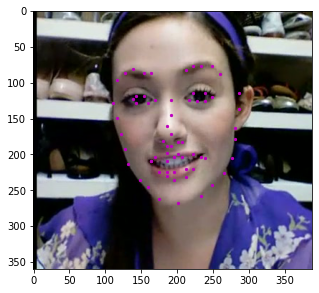

In [11]:
# Display an image with keypoints
n = 75
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
img = mpimg.imread(os.path.join('/dataset/training/', image_name))
print(f'Shape of image: {img.shape}')
show_keypoints(img, key_pts)
plt.show()

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.


In [14]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
  def __init__(self,csv_file, root_dir, transform=None):
    self.key_pts_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.key_pts_frame)
  
  def __getitem__(self, idx):
    image_name = os.path.join(self.root_dir, self.key_pts_frame.iloc[idx,0])
    image = mpimg.imread(image_name)

    # if image has an alpha color channel, get rid of it
    if image.shape[2] == 4:
      image = image[:,:,0:3]
    
    key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
    key_pts = key_pts.astype('float').reshape(-1,2)
    sample = {"image":image, "key_pts":key_pts}

    if self.transform:
      sample = self.transform(sample)

    return sample

In [15]:
# Let's initiate this class and display some images
face_dataset = FacialKeypointsDataset(csv_file='/dataset/training_frames_keypoints.csv', root_dir='/dataset/training')

# print some stats about the dataset
print(f'Length of Dataset: {len(face_dataset)}')

Length of Dataset: 3462


1/3 	 (196, 165, 3) 	 (68, 2)


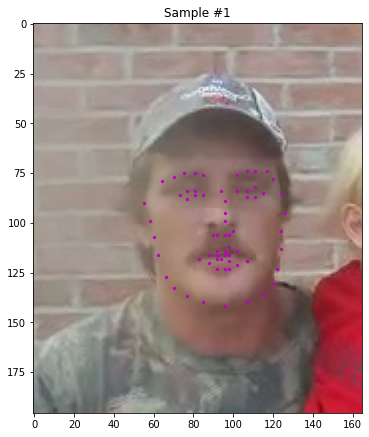

2/3 	 (240, 200, 3) 	 (68, 2)


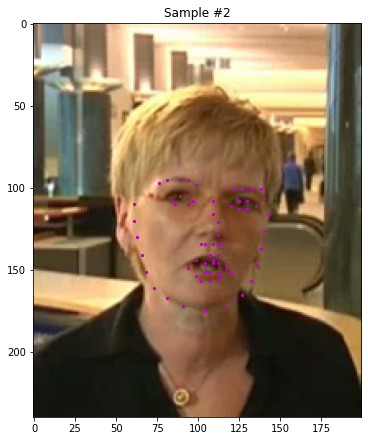

3/3 	 (168, 149, 3) 	 (68, 2)


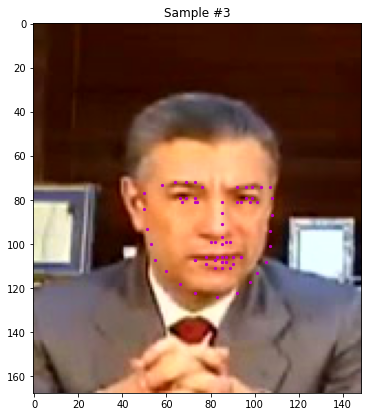

In [17]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
  # define the size of images
  fig = plt.figure(figsize=(20,10))

  # randomly select a sample
  rand_i = np.random.randint(0,len(face_dataset))
  sample = face_dataset[rand_i]

  # print the shape of the image and the keypoints
  print(f'{i+1}/{num_to_display} \t {sample["image"].shape} \t {sample["key_pts"].shape}')

  ax = plt.subplot(1, num_to_display, i+1)
  ax.set_title(f'Sample #{i+1}')

  show_keypoints(image=sample['image'], key_pts=sample['key_pts'])

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)


In [27]:
import torch
from torchvision import transforms, utils

class Normalize(object):
  """ Convert a color image to grayscale and normalize the color range to [0,1] """
  
  def __call__(self,sample):
    image, key_pts = sample['image'], sample['key_pts']

    image_copy = np.copy(image)
    key_pts_copy = np.copy(key_pts)

    # convert image to grayscale
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale range from [0,255] to [0,1]
    image_copy = image_copy / 255.0

    # scale keypoints to be centered around 0 with a range of [-1,1]
    # mean = 100, sqrt = 50, so pts should be (pts-100) / 50

    key_pts_copy = (key_pts_copy - 100) / 50.0

    return {"image":image_copy, "key_pts":key_pts_copy}

class Rescale(object):
  """ Rescale the image in a sample to a given size"""

  def __init__(self, output_size):
    assert isinstance(output_size, (int,tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['key_pts']
    h,w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
        new_h, new_w = self.output_size * h / w , self.output_size
      else:
        new_h, new_w = self.output_size , self.output_size * w / h
    else:
      new_h, new_w = self.output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w,new_h))

    # scale the pts, too
    key_pts = key_pts * [new_w / w, new_h / h]

    return {"image":img, "key_pts":key_pts}

class RandomCrop(object):
  """ Crop Randomly the image in a sample"""

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2
      self.output_size = output_size
    
  def __call__(self, sample):
    image, key_pts = sample['image'], sample['key_pts']
    
    h,w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top+new_h, left:left+new_w]

    key_pts = key_pts - [left, top]
    
    return {"image":image, "key_pts":key_pts}

class ToTensor(object):
  """ Convert ndarrays in samplt to Tensors. """

  def __call__(object, sample):
    image, key_pts = sample['image'], sample['key_pts']

    # if image has no grayscale color channel, add one
    if len(image.shape) == 2:
      # add the third color dim
      image = image.reshape(image.shape[0], image.shape[1], 1)
    
    # swap color axis, because
    # Numpy image: H x W x C
    # Tensor image: C x H x W
    image = image.transpose((2,0,1))

    return {'image': torch.from_numpy(image), 'key_pts': torch.from_numpy(key_pts)}

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. As you look at each transform, note that, in this case, **order does matter**. For example, you cannot crop a image using a value smaller than the original image (and the orginal images vary in size!), but, if you first rescale the original image, you can then crop it to any size smaller than the rescaled size.

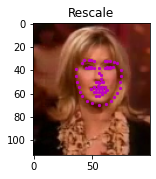

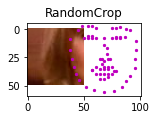

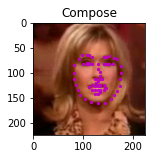

In [28]:
rescale = Rescale(100)
crop = RandomCrop(50)

composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transform to the sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
  transformed_sample = tx(sample)

  ax = plt.subplot(1,3,i+1)
  plt.tight_layout()
  ax.set_title(type(tx).__name__)
  show_keypoints(transformed_sample['image'], transformed_sample['key_pts'])

plt.show()

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

In [29]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/dataset/training_frames_keypoints.csv',
                                             root_dir='/dataset/training', 
                                             transform = data_transform)

In [31]:
print(f'Number of images: {len(transformed_dataset)}')

for i in range(5):
  sample = transformed_dataset[i]
  print(f'{i} \t {sample["image"].size()} \t {sample["key_pts"].size()}')

Number of images: 3462
0 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
1 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
2 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
3 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])
4 	 torch.Size([1, 224, 224]) 	 torch.Size([68, 2])


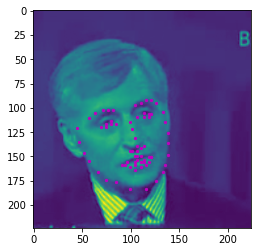

In [41]:
# Visualizing one sample from transformed_dataset
idx = 899
sample = transformed_dataset[idx]
image, key_pts = sample["image"], sample["key_pts"]
key_pts = (key_pts * 50) + 100  # Denormalizing keypoints
show_keypoints(np.squeeze(image), key_pts)

# 2. Define the Network Architecture

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # input_size: 1x224x224

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # output_size: 16 x 224 x 224
        I.xavier_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # output_size: 32 x 112 x 112 after pooling
        I.xavier_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) # output_size: 32 x 56 x 56 after pooling
        I.xavier_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # output_size: 64 x 28 x 28 after pooling
        I.xavier_normal_(self.conv3.weight)

        # pool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dense layers
        self.fc1 = nn.Linear(in_features=64*14*14, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=136) # output_size: batch_size x 136

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Relu Layer
        self.relu = nn.ReLU()

    def forward(self, x):
        if (x.shape[1] != 1):
          err_msg = "Error: Input image must be grayscaled"
          print(err_msg)
          return None
        if (x.shape[2] != x.shape[3]):
          err_msg = "Error: Input image must be square shaped"
          print(err_msg)
          return None

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        # flatten image 
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [97]:
# Testing our model
X = torch.randn(64,1,224,224)
net = Net()
output = net(X)
if output is not None:
  print(output.shape)

torch.Size([64, 136])


## Transform the dataset

In [99]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(226),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [103]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/dataset/training_frames_keypoints.csv',
                                             root_dir='/dataset/training',
                                             transform=data_transform)

print(f'Number of images: {len(transformed_dataset)}')

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['key_pts'].size())

Number of images: 3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and Loading data

In [150]:
# load training data in batches
batch_size = 60
train_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True,num_workers=8)

## Before Training

In [152]:
# load in the test data, using the dataset class
# AND apply the data_transform defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/dataset/test_frames_keypoints.csv',
                                             root_dir='/dataset/test/',
                                             transform=data_transform)

In [153]:
# load the test data in batches
batch_size = 60

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [107]:
# test the model on a batch of test images
def net_sample_output():
  for i, sample in enumerate(test_loader):
    images, key_pts = sample['image'], sample['key_pts']

    # convert images to float tensor
    images = images.type(torch.FloatTensor)

    # forward pass to get the net output
    output_pts = net(images)

    # reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.reshape(output_pts.shape[0], 68, -1)

    # break after first image is tested
    if i == 0:
      return images, output_pts, key_pts

In [128]:
test_images, test_outputs, gt_pts = net_sample_output()
print(images.shape)
print(test_outputs.shape)
print(gt_pts.shape)

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


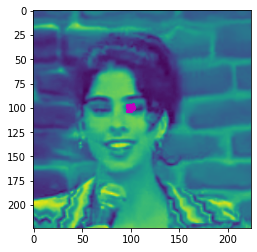

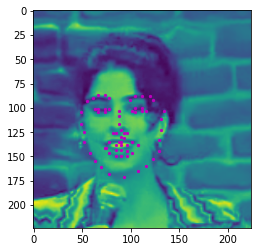

In [129]:
# Let's plot one outputed test image
idx = 7
image = test_images[idx].data
image = image.numpy()
image = image.transpose((1,2,0))

output_pts = test_outputs[idx].data
output_pts = (output_pts * 50) + 100 

key_pts = gt_pts[idx]
key_pts = (key_pts * 50) + 100 

show_keypoints(np.squeeze(image), output_pts)
show_keypoints(np.squeeze(image), key_pts)

In [120]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

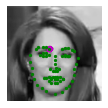

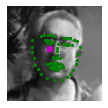

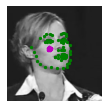

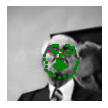

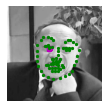

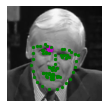

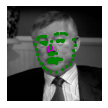

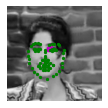

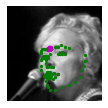

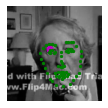

In [130]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

In [132]:
## TODO: Define the loss and optimization
import torch.optim as optim

lr = 0.001

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=lr)


In [154]:
def train_net(n_epochs, model_path):

    # prepare the net for training
    net.train()
    train_loss_per_epoch = []
    min_loss_per_epoch = np.inf
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['key_pts']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/(10*batch_i+1)))
                # running_loss = 0.0

        avg_loss_per_epoch = running_loss / len(train_loader)
        train_loss_per_epoch.append(avg_loss_per_epoch)
        print(f'Epoch: {epoch+1}/{n_epochs} \t Training Loss: {avg_loss_per_epoch:.6f}')
        if avg_loss_per_epoch < min_loss_per_epoch:
          print(f'Average Loss per epoch decreased ({min_loss_per_epoch} -> {avg_loss_per_epoch})\tSaving Model...')
          min_loss_per_epoch = avg_loss_per_epoch
          torch.save(net.state_dict(), model_path)
    print('Finished Training')
    return train_loss_per_epoch


In [190]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

model_path = "/content/drive/MyDrive/Facial_Key_Points_Detection/Output_Models/keypoints_model_1.pt"
training_loss = train_net(n_epochs,model_path)
plt.plot(training_loss, colog='r')
plt.title('Plot of training loss')

## Test Data

In [156]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([60, 1, 224, 224])
torch.Size([60, 68, 2])
torch.Size([60, 68, 2])


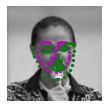

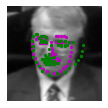

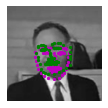

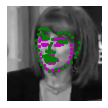

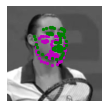

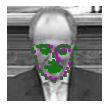

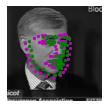

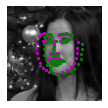

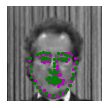

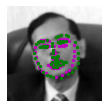

In [186]:
# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

## Feature visualization

[[-0.15813637 -0.1275247   0.03607935]
 [-0.02238496  0.20722803  0.06164504]
 [-0.16391787 -0.00448783 -0.028829  ]]
(3, 3)


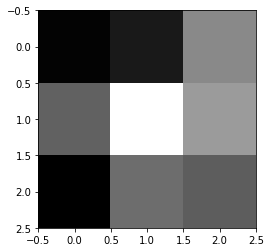

In [160]:
# Get the weights in the first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Filter an image to see the effect of the convolutional kernel

Number of filters in first layer: 16
Filter:
[[-0.04426856 -0.03457164  0.04633884]
 [ 0.0516458  -0.06380203 -0.21453375]
 [ 0.20710267 -0.03574165  0.02231497]]


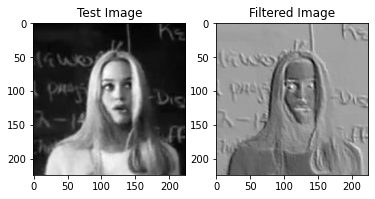

In [189]:
##TODO: load in and display any image from the transformed test dataset

idx = 45
sample = test_dataset[idx]
image = sample["image"]
image = np.squeeze(image)

weights = net.conv1.weight.data
w = weights1.numpy()

print(f'Number of filters in first layer: {len(w)}') # 16

filter_idx = 15
kernel = w[filter_idx][0]
print('Filter:')
print(kernel)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights to the test image

filtered_image = cv2.filter2D(np.float32(image), -1, kernel)

plt.subplot(1,2,1)
plt.title('Test Image')
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title('Filtered Image')
plt.imshow(filtered_image, cmap='gray')
plt.show()

# Loading in trained model

In [192]:
import torch 

net = Net()

model_path = "/content/drive/MyDrive/Facial_Key_Points_Detection/Output_Models/keypoints_model_1.pt"

net.load_state_dict(torch.load(model_path))
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=136, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)
